In [2]:
from __future__ import annotations

import os
import zipfile
import glob
import pickle
import math
import random
import warnings
from collections import Counter
from functools import lru_cache
from pathlib import Path
from typing import Tuple, Dict, Any

import numpy as np
import pandas as pd
from langdetect import DetectorFactory, detect
from scipy.stats import entropy as shannon_entropy
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
import xgboost as xgb
import joblib
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import logging, time

In [3]:
# ──────────────────────────────  CONFIG  ────────────────────────────────
log = logging.getLogger(__name__)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
npr.seed(SEED)
DetectorFactory.seed = SEED

DATA_DIR = Path("data")
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)
SSA_ZIP = DATA_DIR / "names.zip"
SSA_STATE_ZIP = DATA_DIR / "namesbystate.zip"
CO_FILE = "STATE.CO.txt"
RATED_BOY = DATA_DIR / "baby_name_boy.txt"
RATED_GIRL = DATA_DIR / "baby_name_girl.txt"

# Western European language ISO codes (for simple flag feature)
WESTERN_LANGS = {"de", "en", "es", "it", "el", "nl", "da"}

In [4]:
# ──────────────────────────────  HELPERS  ───────────────────────────────

def unzip_once(zip_path: Path, out_dir: Path) -> None:
    if not out_dir.exists():
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(out_dir)


def cache_pickle(obj: Any, path: Path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)


def load_pickle(path: Path):
    with open(path, "rb") as f:
        return pickle.load(f)


@lru_cache(maxsize=None)
def language_root(name: str) -> int:
    """Return 1 if detected language in WESTERN_LANGS else 0."""
    try:
        return int(detect(name) in WESTERN_LANGS)
    except Exception:  # fall-back for very short / unknown names
        return 0


# Vectorised syllable count via simple heuristic
VOWELS = set("aeiouy")

def syllable_count_vec(names: pd.Series) -> pd.Series:
    def _count(name: str) -> int:
        name = name.lower()
        count = int(name[0] in VOWELS)
        for i in range(1, len(name)):
            if name[i] in VOWELS and name[i - 1] not in VOWELS:
                count += 1
        if name.endswith("e") and count > 1:
            count -= 1
        return max(count, 1)

    return names.apply(_count)


def name_entropy_vec(names: pd.Series) -> pd.Series:
    """
    Shannon (character) entropy of each name, base-2.

    Example:
        "Ava"  → counts = [2,1] for {'a':2,'v':1}
               → entropy ≈ 0.918 bits
    """
    def _entropy(name: str) -> float:
        counts = np.fromiter(Counter(name.lower()).values(), dtype=float)
        return shannon_entropy(counts, base=2)

    return names.apply(_entropy)

In [5]:
# ──────────────────────────────  DATA  ───────────────────────────────

def load_aggregated_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Return (aggregated_all, aggregated_CO). Each with columns
    Name, Sex, Total_Count, Most_Popular_Year, Count_Recent
    """
    # 1. unzip SSA national timeline
    all_dir = DATA_DIR / "ssa_all"
    unzip_once(SSA_ZIP, all_dir)
    files = sorted(glob.glob(str(all_dir / "yob*.txt")))

    df_list = []
    for fp in tqdm(files, desc="Reading SSA national files"):
        year = int(Path(fp).stem[-4:])
        df = pd.read_csv(fp, names=["Name", "Sex", "Count"])
        df["Year"] = year
        df_list.append(df)
    all_names = pd.concat(df_list, ignore_index=True)

    agg_all = (
        all_names.groupby(["Name", "Sex"]).agg(
            Total_Count=("Count", "sum"),
            Most_Popular_Year=("Year", lambda x: x.value_counts().idxmax()),
        )
        .reset_index()
    )

    recent_year_all = all_names["Year"].max()
    recent_counts = (
        all_names.query("Year == @recent_year_all")[["Name", "Sex", "Count"]]
        .rename(columns={"Count": "Count_Recent"})
    )
    agg_all = agg_all.merge(recent_counts, on=["Name", "Sex"], how="left").fillna(0)

    # 2. Colorado-specific timeline
    state_dir = DATA_DIR / "ssa_state"
    unzip_once(SSA_STATE_ZIP, state_dir)
    co_df = pd.read_csv(state_dir / CO_FILE, header=None, names=["State", "Sex", "Year", "Name", "Count"])

    agg_co = (
        co_df.groupby(["Name", "Sex"]).agg(
            CO_Total_Count=("Count", "sum"),
            CO_Most_Popular_Year=("Year", lambda x: x.value_counts().idxmax()),
        )
        .reset_index()
    )
    recent_year_co = co_df["Year"].max()
    recent_co_counts = (
        co_df.query("Year == @recent_year_co")[["Name", "Sex", "Count"]]
        .rename(columns={"Count": "Count_CO_Recent"})
    )
    agg_co = agg_co.merge(recent_co_counts, on=["Name", "Sex"], how="left").fillna(0)

    # Final merge
    combined = agg_all.merge(agg_co, on=["Name", "Sex"], how="left").fillna(0)
    return combined, agg_co


def load_rated_names(agg: pd.DataFrame) -> pd.DataFrame:
    boys = pd.read_csv(RATED_BOY, names=["Name", "Rating", "Sex"])
    girls = pd.read_csv(RATED_GIRL, names=["Name", "Rating", "Sex"])
    rated = pd.concat([boys, girls], ignore_index=True)
    rated = rated.merge(agg, on=["Name", "Sex"], how="left").fillna(0)
    return rated

In [6]:
# ───────────────────────────  FEATURE ENGINEERING  ─────────────────────

def engineer_features(df: pd.DataFrame, *, cache_path: Path | None = None) -> pd.DataFrame:
    if cache_path and cache_path.exists():
        return load_pickle(cache_path)

    out = df.copy()
    out["Length"] = out["Name"].str.len()
    out["Vowels"] = out["Name"].str.lower().str.count(r"[aeiou]")
    out["Consonants"] = out["Length"] - out["Vowels"]
    out["Sex"] = out["Sex"].map({"M": 1, "F": 0})
    out["Has_Repeating"] = out["Name"].apply(lambda x: int(max(Counter(x).values()) > 1))
    out["Ends_with_Vowel"] = out["Name"].str[-1].str.lower().isin(VOWELS).astype(int)
    out["Starts_with_Vowel"] = out["Name"].str[0].str.lower().isin(VOWELS).astype(int)
    out["Syllable_Count"] = syllable_count_vec(out["Name"])
    out["Name_Entropy"] = name_entropy_vec(out["Name"])
    out["Language_Root"] = out["Name"].apply(language_root)

    if cache_path:
        cache_pickle(out, cache_path)
    return out

In [7]:
# ───────────────────────────  MODEL TRAINING  ─────────────────────────

def build_models() -> Dict[str, Tuple[Any, Dict[str, Any]]]:
    return {
        "xgb": (
            xgb.XGBClassifier(
                objective="multi:softprob",
                num_class=10,  # ratings 0-9 internally
                eval_metric="mlogloss",
                random_state=SEED,
            ),
            {
                "clf__n_estimators": npr.randint(100, 400, 50),
                "clf__learning_rate": np.linspace(0.01, 0.3, 30),
                "clf__max_depth": npr.randint(3, 8, 30),
            },
        ),
        "rf": (
            RandomForestClassifier(class_weight="balanced", random_state=SEED),
            {
                "clf__n_estimators": npr.randint(100, 400, 50),
                "clf__max_depth": [None] + list(npr.randint(5, 25, 20)),
            },
        ),
        "svm": (
            SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=SEED),
            {
                "clf__C": np.logspace(-2, 2, 50),
                "clf__gamma": np.logspace(-4, 0, 50),
            },
        ),
        "knn": (
            KNeighborsClassifier(),
            {
                "clf__n_neighbors": npr.randint(3, 25, 22),
                "clf__weights": ["uniform", "distance"],
                "clf__metric": ["euclidean", "manhattan"],
            },
        ),
    }


def build_pipeline(clf) -> Pipeline:
    numeric_cols = [
        "Total_Count",
        "Most_Popular_Year",
        "Count_Recent",
        "CO_Total_Count",
        "Count_CO_Recent",
        "CO_Most_Popular_Year",
        "Length",
        "Vowels",
        "Consonants",
        "Sex",
        "Has_Repeating",
        "Ends_with_Vowel",
        "Starts_with_Vowel",
        "Syllable_Count",
        "Name_Entropy",
        "Language_Root",
    ]

    pre = ColumnTransformer([
        ("num", StandardScaler(), numeric_cols),
    ])

    # Optional PCA for distance-based algos will be chained externally where needed
    return Pipeline([
        ("pre", pre),
        ("clf", clf),
    ])

In [8]:
# ───────────────────────────  TRAIN / EVAL LOOP  ───────────────────────

def train_models(X: pd.DataFrame, y: pd.Series) -> Dict[str, Any]:
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    for name, (clf, param_dist) in tqdm(build_models().items(), desc="Model training"):
        pipe = build_pipeline(clf)
        search = RandomizedSearchCV(
            pipe,
            param_distributions=param_dist,
            n_iter=40,
            cv=cv,
            scoring="f1_weighted",
            random_state=SEED,
            verbose=1,
            n_jobs=-1,
        )
        search.fit(X, y)
        results[name] = {
            "best": search.best_estimator_,
            "f1": search.best_score_,
            "params": search.best_params_,
        }
        joblib.dump(search.best_estimator_, ARTIFACT_DIR / f"{name}_model.joblib")
    return results


def evaluate(model, X_test, y_test, class_labels, title):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred)

    sns.set(font_scale=1.0)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        (cm / cm.sum(axis=1, keepdims=True)) * 100,
        annot=True,
        fmt=".1f",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.title(f"{title}\nAcc={acc:.2f} | F1={f1:.2f}")
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.show()
    return acc, f1

DEBUG 13:40:31 | ▶ Starting pipeline (seed=42)…


Reading SSA national files:   0%|          | 0/143 [00:00<?, ?it/s]

DEBUG 13:40:38 | Loaded: combined=(113882, 8)  rated=(2142, 9)
DEBUG 13:44:23 | Feature dfs: combined_fe=(113882, 17)  rated_fe=(2142, 18)
DEBUG 13:44:23 | Using 16 feature columns
DEBUG 13:44:23 | X dtypes summary:
int64      11
float64     5
Name: count, dtype: int64
DEBUG 13:44:23 | Train=(1713, 16)  Test=(429, 16)
INFO 13:44:23 | …CV for XGB


Model training:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
INFO 13:45:05 | ✓ xgb done in 41.7s
INFO 13:45:05 | …CV for RF


Model training:   0%|          | 0/4 [00:00<?, ?it/s]

/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
INFO 13:45:37 | ✓ rf done in 32.4s
INFO 13:45:37 | …CV for SVM


Model training:   0%|          | 0/4 [00:00<?, ?it/s]

/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
INFO 13:46:08 | ✓ svm done in 31.0s
INFO 13:46:08 | …CV for KNN


Model training:   0%|          | 0/4 [00:00<?, ?it/s]

/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
INFO 13:46:40 | ✓ knn done in 32.3s
INFO 13:46:40 | 
=== Held-out test set ===
DEBUG 13:46:40 | Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG 13:46:40 | Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG 13:46:40 | findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG 13:46:40 | findfont: score(FontEntry(fname='/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG 13:46:40 | findfont: score(FontEntry(fname='/home/sd205521/miniconda3/envs/huggingface/lib/python3.12/site

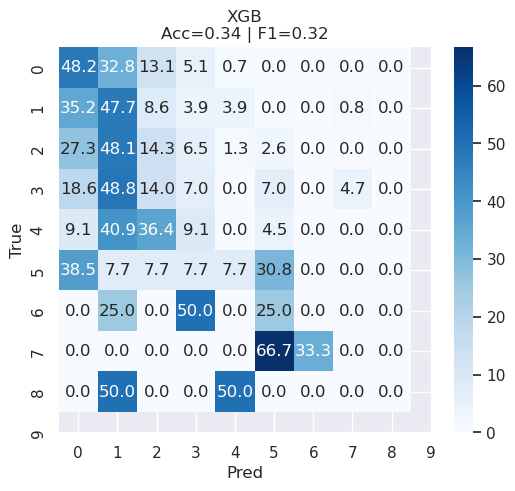

INFO 13:46:40 | XGB  acc=0.338  f1=0.316
DEBUG 13:46:40 | locator: <matplotlib.ticker.AutoLocator object at 0x7fe33510f5f0>


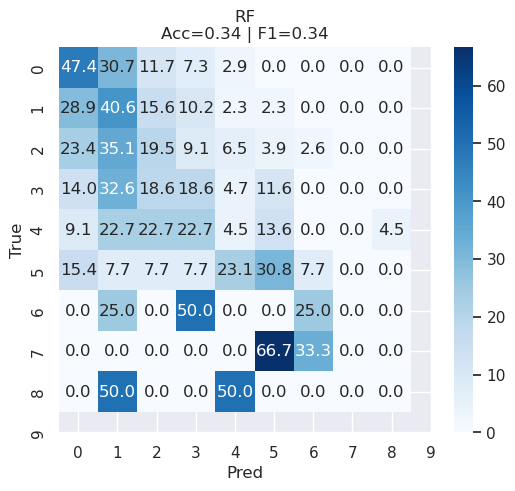

INFO 13:46:41 | RF  acc=0.340  f1=0.338
DEBUG 13:46:41 | locator: <matplotlib.ticker.AutoLocator object at 0x7fe3352fb620>


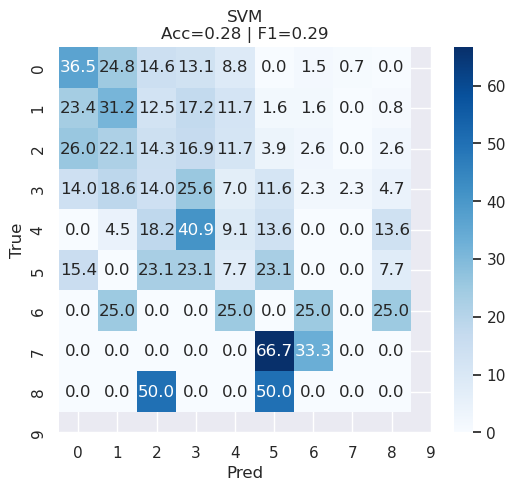

INFO 13:46:41 | SVM  acc=0.275  f1=0.292
DEBUG 13:46:41 | locator: <matplotlib.ticker.AutoLocator object at 0x7fe33519c710>


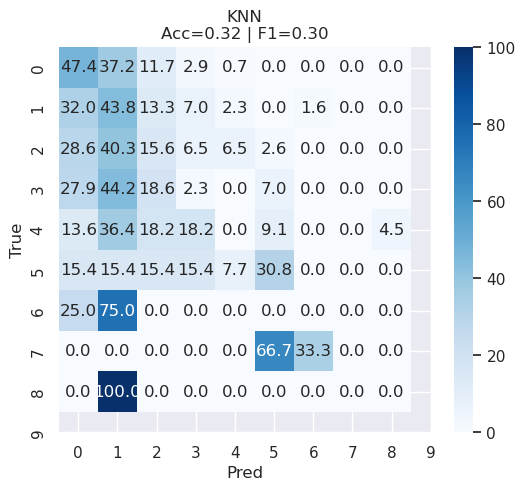

INFO 13:46:41 | KNN  acc=0.322  f1=0.302


Inference on all names:   0%|          | 0/4 [00:00<?, ?it/s]

INFO 13:46:47 | Top-50 exported → artifacts/top50_boy_names.csv
DEBUG 13:46:47 | 🏁 Finished in 375.6s


In [9]:
debug = True

lvl = logging.DEBUG if debug else logging.INFO
logging.basicConfig(
    level=lvl,
    format="%(levelname)s %(asctime)s | %(message)s",
    datefmt="%H:%M:%S",
)

t0 = time.perf_counter()
log.debug("▶ Starting pipeline (seed=%d)…", SEED)

# ── Data ingest ───────────────────────────
combined_df, _ = load_aggregated_data()
rated = load_rated_names(combined_df)
log.debug("Loaded: combined=%s  rated=%s", combined_df.shape, rated.shape)

# ── Feature engineering (+ caching) ───────
combined_fe = engineer_features(
    combined_df, cache_path=ARTIFACT_DIR / "all_names_fe.pkl"
)
rated_fe = engineer_features(
    rated, cache_path=ARTIFACT_DIR / "rated_names_fe.pkl"
)
log.debug("Feature dfs: combined_fe=%s  rated_fe=%s",
          combined_fe.shape, rated_fe.shape)

feature_cols = [c for c in combined_fe.columns
                if c not in {"Name"} and not c.endswith("_Pred")]
log.debug("Using %d feature columns", len(feature_cols))

X = rated_fe[feature_cols]
y = rated_fe["Rating"].astype(int) - 1     # 0-based
log.debug("X dtypes summary:\n%s", X.dtypes.value_counts())

# ── Train / test split ────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
log.debug("Train=%s  Test=%s", X_train.shape, X_test.shape)

# ── Model training ────────────────────────
models = {}
for model_name, payload in build_models().items():
    t1 = time.perf_counter()
    log.info("…CV for %s", model_name.upper())
    models.update(train_models(X_train, y_train))
    log.info("✓ %s done in %.1fs", model_name, time.perf_counter() - t1)

# ── Evaluation ────────────────────────────
log.info("\n=== Held-out test set ===")
class_labels = np.sort(y.unique())
for name, d in models.items():
    acc, f1 = evaluate(d["best"], X_test, y_test, class_labels, name.upper())
    d["test_acc"], d["test_f1"] = acc, f1
    log.info("%s  acc=%.3f  f1=%.3f", name.upper(), acc, f1)

# ── Inference on full list ─────────────────
for name, d in tqdm(models.items(), desc="Inference on all names"):
    col = f"{name.upper()}_Predicted_Rating"
    combined_fe[col] = d["best"].predict(combined_fe[feature_cols])

pred_cols = [c for c in combined_fe.columns if c.endswith("_Predicted_Rating")]
combined_fe["Average_Predicted_Rating"] = (
    combined_fe[pred_cols].mean(axis=1).round(1)
)
combined_fe[pred_cols + ["Average_Predicted_Rating"]] += 1  # back to 1-10

top50 = (
    combined_fe.query("Sex == 1")
    .sort_values("Average_Predicted_Rating", ascending=False)
    .head(50)[["Name", "Average_Predicted_Rating"] + pred_cols]
)
out_path = ARTIFACT_DIR / "top50_boy_names.csv"
top50.to_csv(out_path, index=False)
log.info("Top-50 exported → %s", out_path)

log.debug("Finished in %.1fs", time.perf_counter() - t0)